In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import random
import time
import json
import seaborn as sn
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
! pip install sklearn_crfsuite

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import re
import math, string
import sklearn_crfsuite

# from sklearn.metrics import make_scorer
# from sklearn.metrics import accuracy_score
# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import RandomizedSearchCV
# from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics
# from itertools import chain
# from sklearn.preprocessing import MultiLabelBinarizer

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
import  nltk
from nltk import word_tokenize

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('universal_tagset')
nltk.download('treebank')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.
[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Unzipping corpora/treebank.zip.


True

In [ ]:
!ls

POStest-in.txt	 POStr-in.txt	POSvalid-in.txt   sample_data
POStest-out.txt  POStr-out.txt	POSvalid-out.txt


In [ ]:
def load_dataset(X_file,y_file):
  '''laod data set and crete list of tuples (word,tag) '''
  X=[]
  with open(X_file) as f:
    # X_train=f.read().splitlines()
    for line in f:
      X.append(word_tokenize(line))

  y=[]
  with open(y_file) as f:
    for line in f:
      y.append(eval(line))

  dataset= [[(x,y) for x,y in zip(sublist1, sublist2)] \
                  for sublist1, sublist2 in zip(X, y)]
  return dataset

In [ ]:
train_set=load_dataset("POStr-in.txt","POStr-out.txt")
val_set=load_dataset("POSvalid-in.txt","POSvalid-out.txt")
test_set=load_dataset("POStest-in.txt","POStest-out.txt")


In [ ]:
def word2features(sent, i):
    word = sent[i][0]

    features = {
        'bias': 1.0,
        'word': word,
        'len(word)': len(word),
        'word[:4]': word[:4],
        'word[:3]': word[:3],
        'word[:2]': word[:2],
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word[-4:]': word[-4:],
        'word.lower()': word.lower(),
        'word.stemmed': re.sub(r'(.{2,}?)([aeiougyn]+$)',r'\1', word.lower()),
        'word.ispunctuation': (word in string.punctuation),
        'word.isdigit()': word.isdigit(),
    }    
    if i > 0:
        word1 = sent[i-1][0]
        features.update({
            '-1:word': word1,
            '-1:len(word)': len(word1),
            '-1:word.lower()': word1.lower(),
            '-1:word.stemmed': re.sub(r'(.{2,}?)([aeiougyn]+$)',r'\1', word1.lower()),
            '-1:word[:3]': word1[:3],
            '-1:word[:2]': word1[:2],
            '-1:word[-3:]': word1[-3:],
            '-1:word[-2:]': word1[-2:],
            '-1:word.isdigit()': word1.isdigit(),
            '-1:word.ispunctuation': (word1 in string.punctuation),
        })
    else:
        features['BOS'] = True

    if i > 1:
        word2 = sent[i-2][0]
        features.update({
            '-2:word': word2,
            '-2:len(word)': len(word2),
            '-2:word.lower()': word2.lower(),
            '-2:word[:3]': word2[:3],
            '-2:word[:2]': word2[:2],
            '-2:word[-3:]': word2[-3:],
            '-2:word[-2:]': word2[-2:],
            '-2:word.isdigit()': word2.isdigit(),
            '-2:word.ispunctuation': (word2 in string.punctuation),
        })

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        features.update({
            '+1:word': word1,
            '+1:len(word)': len(word1),
            '+1:word.lower()': word1.lower(),
            '+1:word[:3]': word1[:3],
            '+1:word[:2]': word1[:2],
            '+1:word[-3:]': word1[-3:],
            '+1:word[-2:]': word1[-2:],
            '+1:word.isdigit()': word1.isdigit(),
            '+1:word.ispunctuation': (word1 in string.punctuation),
        })

    else:
        features['EOS'] = True    
    if i < len(sent) - 2:
        word2 = sent[i+2][0]
        features.update({
            '+2:word': word2,
            '+2:len(word)': len(word2),
            '+2:word.lower()': word2.lower(),
            '+2:word.stemmed': re.sub(r'(.{2,}?)([aeiougyn]+$)',r'\1', word2.lower()),
            '+2:word[:3]': word2[:3],
            '+2:word[:2]': word2[:2],
            '+2:word[-3:]': word2[-3:],
            '+2:word[-2:]': word2[-2:],
            '+2:word.isdigit()': word2.isdigit(),
            '+2:word.ispunctuation': (word2 in string.punctuation),
        })

    return features


def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [word[1] for word in sent]

def sent2tokens(sent):
    return [word[0] for word in sent]

In [ ]:
Xtrain = [sent2features(s) for s in train_set]
ytrain = [sent2labels(s) for s in train_set]

In [ ]:
X_val = [sent2features(s) for s in val_set]
y_val = [sent2labels(s) for s in val_set]

In [ ]:
crf = sklearn_crfsuite.CRF(
    algorithm = 'lbfgs',
    verbose='true',
    c1 = 0.25,
    c2 = 0.3,
    max_iterations = 200,
    all_possible_transitions=True
)

try:
  crf.fit(Xtrain, ytrain, X_dev=X_val, y_dev=y_val)
except AttributeError:
    pass

loading training data to CRFsuite: 100%|██████████| 6974/6974 [00:14<00:00, 491.09it/s]


loading dev data to CRFsuite: 100%|██████████| 1740/1740 [00:03<00:00, 489.09it/s]



Holdout group: 2

Feature generation
type: CRF1d
feature.minfreq: 0.000000
feature.possible_states: 0
feature.possible_transitions: 1
0....1....2....3....4....5....6....7....8....9....10
Number of features: 974274
Seconds required: 6.396

L-BFGS optimization
c1: 0.250000
c2: 0.300000
num_memories: 6
max_iterations: 200
epsilon: 0.000010
stop: 10
delta: 0.000010
linesearch: MoreThuente
linesearch.max_iterations: 20

Iter 1   time=9.19  loss=634793.85 active=940338 precision=0.004  recall=0.023  F1=0.007  Acc(item/seq)=0.180 0.000  feature_norm=0.50
Iter 2   time=4.32  loss=597840.91 active=935947 precision=0.024  recall=0.031  F1=0.012  Acc(item/seq)=0.149 0.000  feature_norm=0.62
Iter 3   time=3.83  loss=581923.47 active=951404 precision=0.026  recall=0.042  F1=0.024  Acc(item/seq)=0.237 0.000  feature_norm=0.69
Iter 4   time=3.35  loss=557663.31 active=937448 precision=0.075  recall=0.068  F1=0.052  Acc(item/seq)=0.289 0.001  feature_norm=0.98
Iter 5   time=3.36  loss=539904.05 activ

In [ ]:
y_pred=crf.predict(X_val)


In [ ]:
metrics.flat_accuracy_score(y_val, y_pred)

0.9642850221886324

In [ ]:
metrics.flat_recall_score(y_val, y_pred,average='macro')


0.9128126453645274

In [ ]:
metrics.flat_precision_score(y_val, y_pred,average='macro')



0.9502900395095596

In [ ]:
with open('out_file.txt', 'w') as f:
  for sentence in y_pred:
    f.write(f"{sentence}\n")


In [ ]:
train_tagged_words = [ tup for sent in val_set for tup in sent ]

tags = {tag for word,tag in train_tagged_words}


In [ ]:
from sklearn_crfsuite.utils import flatten
from functools import wraps

def _flattens_y(func):
    @wraps(func)
    def wrapper(y_true, y_pred, *args, **kwargs):
        y_true_flat = flatten(y_true)
        y_pred_flat = flatten(y_pred)
        return func(y_true_flat, y_pred_flat, *args, **kwargs)
    return wrapper

In [ ]:
type(y_pred[0][0])

str

In [ ]:
cm

array([[3967,   12,    0, ...,    0,    0,    0],
       [   6, 5567,   32, ...,    5,    0,    0],
       [   0,   26,  662, ...,    0,    0,    0],
       ...,
       [   0,   11,    0, ...,  835,    0,    0],
       [   0,    0,    0, ...,    0,  125,    0],
       [   0,    0,    0, ...,    0,    0,  680]])

In [ ]:
y_true_flat = flatten(y_val)
y_pred_flat = flatten(y_pred)
cm = confusion_matrix(y_true_flat, y_pred_flat,labels=list(tags))

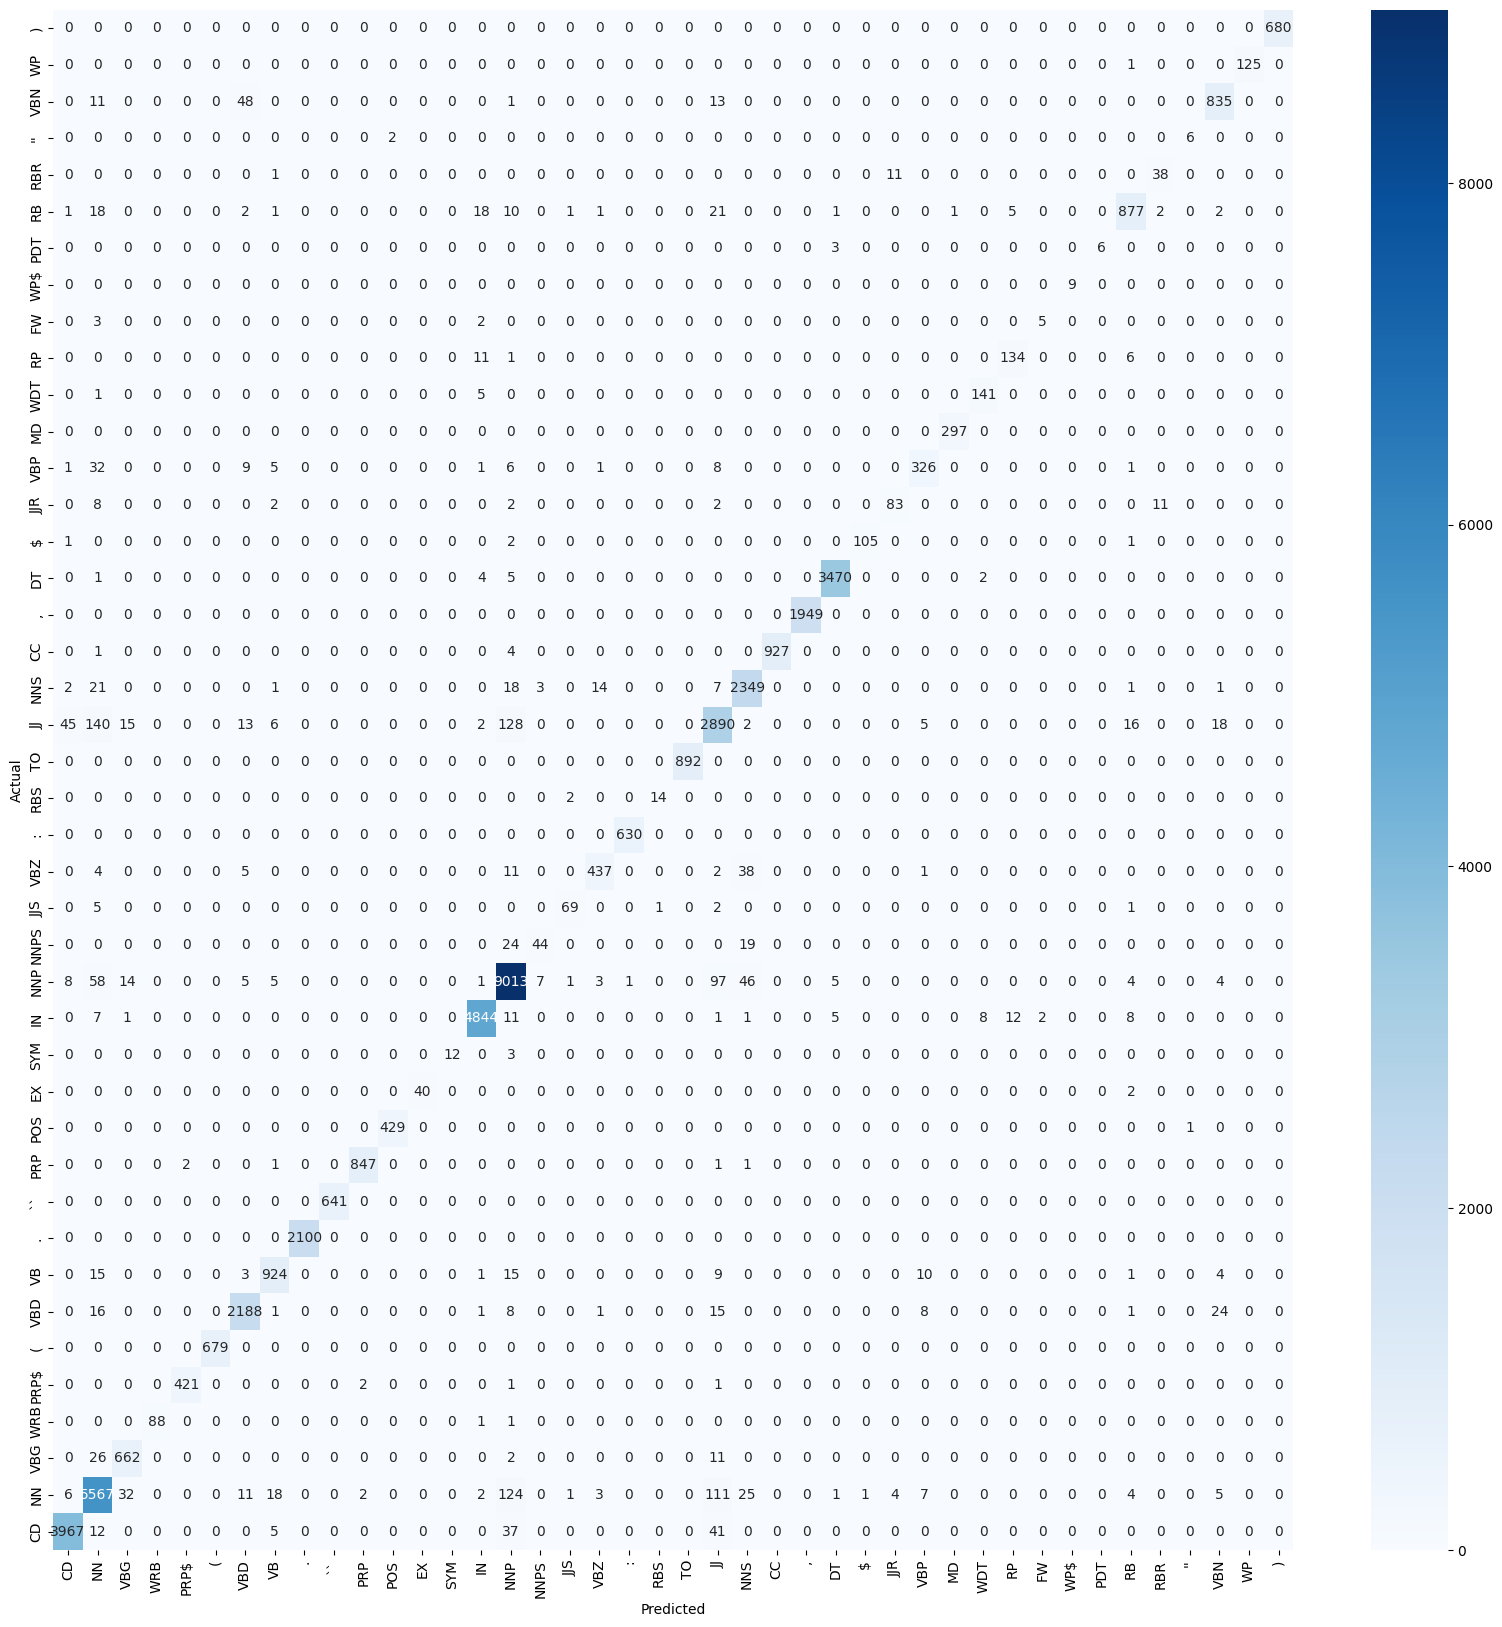

In [ ]:
fig, ax = plt.subplots(figsize=(20, 20))
df_cm = pd.DataFrame(cm, list(tags),list(tags))
ax = sn.heatmap(df_cm, annot=True,ax=ax, cmap='Blues',fmt='g')
# ax.set_ylim(0, 21) 
plt.xlabel("Predicted") 
plt.ylabel("Actual") 
ax.invert_yaxis() 
plt.show()

In [ ]:
import joblib
import os

OUTPUT_PATH = "./"
OUTPUT_FILE = "pos_crf_model"

if not os.path.exists(OUTPUT_PATH):
    os.mkdir(OUTPUT_PATH)

joblib.dump(crf, os.path.join(OUTPUT_PATH, OUTPUT_FILE))

['./pos_crf_model']

In [ ]:
# create pos for next question

In [ ]:
def load_test_dataset(X_file):
  '''laod data set and crete list of tuples (word,tag) '''
  X=[]
  with open(X_file) as f:
    # X_train=f.read().splitlines()
    for line in f:
      X.append(word_tokenize(line))

  # y=[]
  # with open(y_file) as f:
  #   for line in f:
  #     y.append(eval(line))


  dataset= [[(x,y) for x,y in zip(sublist1, sublist2)] \
                  for sublist1, sublist2 in zip(X, X)]
  return dataset

In [ ]:
train_set_ner=load_test_dataset("NERtr_in.txt")
val_set_ner=load_test_dataset("NERvalid_in.txt")
test_set_ner=load_test_dataset("NERtest_in.txt")


In [ ]:
Xtrain_ner = [sent2features(s) for s in train_set_ner]
ytrain_ner = crf.predict(Xtrain_ner)

with open('pos_tag_train_ner.txt', 'w') as f:
  for sentence in ytrain_ner:
    f.write(f"{sentence}\n")

In [ ]:
X_val_ner = [sent2features(s) for s in val_set_ner]
y_val_ner = crf.predict(X_val_ner)
with open('pos_tag_val_ner.txt', 'w') as f:
  for sentence in y_val_ner:
    f.write(f"{sentence}\n")
    

In [ ]:
X_test_ner = [sent2features(s) for s in test_set_ner]
y_test_ner = crf.predict(X_test_ner)
with open('pos_tag_test_ner.txt', 'w') as f:
  for sentence in y_test_ner:
    f.write(f"{sentence}\n")


# pos embedding
One way to obtain sentence embeddings is by taking the average or maximum of the word embeddings within the sentence as described in towardsdatascience.com. We can use POS tagging to extract the relevant words from each sentence and then calculate the average or maximum of their corresponding word embeddings.


In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from gensim.models import Word2Vec

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
y_pred=crf.predict(["The quick brown fox jumps over the lazy dog"])[0]

In [ ]:
tokens = word_tokenize(text.lower())
# pos_tags = pos_tag(tokens)
pos_tag

<function nltk.tag.pos_tag(tokens, tagset=None, lang='eng')>

In [ ]:
pos_tag=[(x,y) for x,y in zip( tokens,y_pred)]
[word for word, tag in pos_tag  if tag.startswith('N') or tag.startswith('V') or tag.startswith('J')]


['quick', 'jumps', 'lazy']

True

In [ ]:
def preprocess_text(text):
    # Tokenize the text
    tokens = word_tokenize(text.lower())
    
    
    
    # POS tags list of (word, tag)
    pos_tags = [(x,y) for x,y in zip(tokens,crf.predict([text])[0])]

    pos_words = [word for word, tag in pos_tags if tag.startswith('N') or tag.startswith('V') or tag.startswith('J')]
    # Filter out stop words from outputs
    stop_words = set(stopwords.words('english'))
    pos_words = [word for word in pos_words if word not in stop_words and word.isalpha()]
    
    return pos_words

In [ ]:
preprocess_text('The quick brown fox jumps over  the lazy dog')

['quick', 'jumps', 'lazy']

In [ ]:
def sentence_embedding(text):
    # Preprocess the text and extract the relevant words
    pos_words = preprocess_text(text)
    
    # Train a Word2Vec model on the relevant words
    model = Word2Vec([pos_words], min_count=1)
    
    # Calculate the word embeddings for the relevant words
    word_embeddings = [model.wv[word] for word in pos_words]
    
    # Calculate the sentence embedding as the average of the word embeddings
    sentence_embedding = sum(word_embeddings) / float(len(word_embeddings))
    
    return sentence_embedding

In [ ]:
text = "The quick brown fox jumps over the lazy dog"
embedding = sentence_embedding(text)
print(embedding)


[-3.0204505e-03  2.3264962e-03  1.1601960e-03  4.4585820e-03
  1.9441830e-03 -1.9793583e-03  1.2970631e-03  5.8876574e-03
 -5.3908695e-03 -1.2438027e-03  7.7765313e-04 -4.3555088e-03
 -2.7508973e-04  4.8439917e-03  1.9943607e-03 -2.2147025e-04
  4.9457778e-03  6.1484794e-03 -6.8439203e-03 -5.0487719e-03
  8.6510181e-04 -1.4371405e-03  3.7892871e-03 -5.8771656e-03
  7.0237126e-03 -1.7782957e-03  8.4812683e-04  5.1431102e-03
 -5.2704127e-03  2.2443840e-03  2.6411389e-03 -4.2396737e-03
  5.1102042e-04 -5.1633450e-03 -2.3695573e-03 -2.4422887e-04
  4.8550270e-03  1.1566281e-03  3.6751798e-03  1.2127539e-03
 -2.4331801e-03 -8.3948486e-05 -6.2709409e-03  6.8203761e-04
  2.7954980e-04  4.0425356e-03 -9.6119940e-05  1.7897417e-03
  7.0873619e-04  3.3303697e-03  3.6556055e-04 -2.5534655e-03
 -3.8054634e-03 -1.1705247e-03 -5.2071299e-04 -6.7185797e-04
  3.8936196e-03 -1.5247749e-03 -3.5735935e-03  4.4638631e-03
 -1.9409428e-03 -7.0188398e-05 -1.3348398e-04 -3.7458830e-03
 -1.7202366e-03  5.75797